# imports

In [4]:
import torch
import open_clip
import os
import re
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
import cv2
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import csv
import pickle
import pandas as pd

## select

In [33]:
def topk_above_m(arr,m,k):
    arr = np.array(arr)
    mask = arr>m
    inds = np.where(mask)[0]
    values = arr[inds]
    sorted_inds = inds[np.argsort(-values)]
    if len(sorted_inds)>k:
        return sorted_inds[:k]
    else:
        return sorted_inds

subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12',
                        'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24']
data_path = "/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/splitv3/whiten/Preprocessed_data_250Hz"
embs = ['dif','eeg','img']
date_code = '0707'
results_dir = f'./outputs/contrast/{date_code}'
details_dir = f'./outputs/contrast/{date_code}'
os.makedirs(results_dir, exist_ok=True)
results_file = f'{results_dir}/allsub_eval.csv'
result_mean_dir = f'./outputs/eval/{date_code}'

# iou of vae
iou_k = 10
iou_min = 0.65
sel_all = []
with open(f"{details_dir}/detail_{date_code}.pkl",'rb') as f:
    details = pickle.load(f)

subi = 0
for subi in range(len(subjects)):
    sub = subjects[subi]
    iou_shift = details[subi]["iou_shift"]
    sel_inds = topk_above_m(iou_shift, iou_min, iou_k)
    sel_all.append(sel_inds)

# metrics
result_epo = {
        'ssim': 0.45, # 0.5-11
        'alexnet2': 0.7,
        'alexnet5': 0.8,
        'inception': 0.7,
        'clip': 0.7,
        # 'effnet': effnet,
        'swav': 0.01, # very low
    }
result_detail_dir = f'{result_mean_dir}/{sub}_detail_{embs[0]}.pkl'
with open(result_detail_dir,'rb') as f:
    metrici = pickle.load(f)


In [34]:
sel_all

[array([28, 33, 13,  9, 11,  5, 26]),
 array([ 1, 15, 49,  5, 24, 46, 18,  2, 47,  4]),
 array([32, 20]),
 array([45, 14]),
 array([ 4, 34, 48, 43, 40, 27, 37, 59, 60, 57]),
 array([29, 24, 31, 28, 61, 26]),
 array([11, 52,  3, 15, 22, 51, 39, 34, 12]),
 array([49, 61, 38, 14, 41]),
 array([20, 19,  4, 49, 31, 42, 32]),
 array([29, 35, 42,  3,  7, 55, 47, 12, 44, 38]),
 array([ 5, 49, 38, 15,  1, 44,  9]),
 array([62, 30, 13, 55, 67, 24, 54]),
 array([11, 67, 52, 50, 20, 72,  4, 36, 24, 53]),
 array([ 3, 14, 35, 11, 34, 66,  1, 51, 25]),
 array([42, 32, 56,  8, 48, 47]),
 array([ 7,  3, 34, 56, 35, 40, 63, 50, 43, 26]),
 array([ 2, 47, 55,  9, 46, 14, 11, 39, 53]),
 array([ 8, 27]),
 array([13, 58, 23, 63, 50, 45]),
 array([18,  8,  2, 32, 27, 28, 13, 36]),
 array([27, 50,  5, 10, 30, 49]),
 array([17, 42, 12, 43, 28, 35, 26, 16,  1, 46]),
 array([18,  3,  9, 41, 67, 56, 35, 48, 26, 60]),
 array([46, 14, 59, 17, 44, 23, 57, 13, 50, 38])]

## visual

In [35]:
def visualize_samples(samples, output_dir='visualizations', rows_per_page=5):
    """
    可视化样本，每行显示一个样本的所有图像，可以分多页显示
    
    参数:
        samples: 样本列表，每个样本是包含以下键的字典:
            - 'img': 原图路径或PIL图像
            - 'control_img': VAE生成图路径或PIL图像
            - 'img_gen1'到'img_gen5': diffusion生成图路径或PIL图像
            - 'imgname': 原图文件名
            - 'annotation': 原图标注
        output_dir: 输出目录
        rows_per_page: 每页显示的样本数
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    num_samples = len(samples)
    num_pages = (num_samples + rows_per_page - 1) // rows_per_page
    
    for page in range(num_pages):
        plt.figure(figsize=(20, 3 * rows_per_page))
        start_idx = page * rows_per_page
        end_idx = min((page + 1) * rows_per_page, num_samples)
        
        for i in range(start_idx, end_idx):
            sample = samples[i]
            row_idx = i - start_idx
            
            # 加载所有图像
            img = sample['img'] if isinstance(sample['img'], Image.Image) else Image.open(sample['img'])
            control_img = sample['control_img'] if isinstance(sample['control_img'], Image.Image) else Image.open(sample['control_img'])
            gen_imgs = [
                sample[f'img_gen'] if isinstance(sample[f'img_gen'], Image.Image) else Image.open(sample[f'img_gen'][j])
                for j in range(len(sample[f'img_gen']))
            ]
            
            # 确保所有图像大小一致
            img_size = img.size
            control_img = control_img.resize(img_size)
            gen_imgs = [gen_img.resize(img_size) for gen_img in gen_imgs]
            
            # 将图像转换为numpy数组
            img_arr = np.array(img)
            control_img_arr = np.array(control_img)
            gen_img_arrs = [np.array(gen_img) for gen_img in gen_imgs]
            
            # 创建一行图像: 原图 + VAE图 + 5张生成图
            row_images = [img_arr, control_img_arr] + gen_img_arrs
            titles = ['Original', 'VAE'] + [f'Diffusion {j}' for j in range(len(sample[f'img_gen']))]
            
            # 显示一行图像
            for j, (image, title) in enumerate(zip(row_images, titles)):
                plt.subplot(rows_per_page, 7, row_idx * 7 + j + 1)
                plt.imshow(image)
                plt.title(f"{title}\n{sample['annotation']}", fontsize=8)
                plt.axis('off')
            
            # 在第一个位置添加文件名
            plt.subplot(rows_per_page, 7, row_idx * 7 + 1)
            plt.text(0, -20, sample['imgname'], fontsize=6, ha='left')
        
        plt.tight_layout()
        output_path = os.path.join(output_dir, f'visualization_page_{page+1}.png')
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f'Saved visualization page {page+1} to {output_path}')

def find_folder_ending_with_i(base_dir, target_i):
    """
    查找 base_dir 下名称最后一部分是数字 i 的文件夹
    
    参数:
        base_dir: 要搜索的根目录
        target_i: 目标数字 i
        
    返回:
        匹配的文件夹路径（完整路径），如果未找到则返回 None
    """
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue  # 跳过非文件夹
        
        # 检查文件夹名称的最后一部分是否是数字，并且等于 target_i
        parts = folder_name.split('-')  # 假设用 '-' 分隔
        if not parts:
            continue
        
        last_part = parts[-1]  # 取最后一部分
        if last_part.isdigit() and int(last_part) == target_i:
            return folder_path
    
    return None  # 未找到

def visualize_gen(texts, images, tang_pth, control_pth, gen_pth, gen_n, output_dir):
    gen_size = len(texts)
    gen_samples = []
    for i in range(0,gen_size):
        img = images[i]
        control_img = f'{control_pth}/reconstructed_image_{i}.png'
        imgname = img[60:]
        annotation = texts[i]
        img_gen = []
        file_gen = find_folder_ending_with_i(gen_pth, i)
        for j in range(0,gen_n):
            img_genj = f'{file_gen}/{j}.png'
            img_gen.append(img_genj)
        gen_samples.append(
            {
                'img': img,
                'control_img': control_img,
                'imgname': imgname,
                'img_gen': img_gen,
                'annotation': annotation,
            }
        )
    
    # 调用可视化函数
    visualize_samples(gen_samples,output_dir=output_dir, rows_per_page=20)

def visualize_gen_part(texts, images, tang_pth, control_pth, gen_pth, gen_n, output_dir, step=7):
    gen_size = len(texts)
    gen_samples = []
    for i in range(0,gen_size,step):
        img = images[i]
        control_img = f'{control_pth}/reconstructed_image_{i}.png'
        imgname = img[60:]
        annotation = texts[i]
        img_gen = []
        file_gen = find_folder_ending_with_i(gen_pth, i)
        for j in range(0,gen_n):
            img_genj = f'{file_gen}/{j}.png'
            img_gen.append(img_genj)
        gen_samples.append(
            {
                'img': img,
                'control_img': control_img,
                'imgname': imgname,
                'img_gen': img_gen,
                'annotation': annotation,
            }
        )
    
    # 调用可视化函数
    visualize_samples(gen_samples,output_dir=output_dir, rows_per_page=20)

def visualize_3gens(ind_sub, texts, images, tang_pth, control_pth, gen_pth, gen_n, output_dir, step=7):
    gen_size = len(ind_sub)
    gen_samples = []
    for i in ind_sub:
        img = images[i]
        control_img = f'{control_pth}/reconstructed_image_{i}.png'
        imgname = img[60:]
        annotation = texts[i]

        dif_gen = []
        eeg_gen = []
        imgfeat_gen = []

        file_gen1 = find_folder_ending_with_i(f'{gen_pth}/dif', i)
        file_gen2 = find_folder_ending_with_i(f'{gen_pth}/eeg', i)
        file_gen3 = find_folder_ending_with_i(f'{gen_pth}/img', i)
        for j in range(0,gen_n):
            img_genj = f'{file_gen1}/{j}.png'
            dif_gen.append(img_genj)

            img_genj = f'{file_gen2}/{j}.png'
            eeg_gen.append(img_genj)

            img_genj = f'{file_gen3}/{j}.png'
            imgfeat_gen.append(img_genj)

        gen_samples.append(
            {
                'img': img,
                'control_img': control_img,
                'imgname': imgname,
                'dif_gen': dif_gen,
                'eeg_gen': eeg_gen,
                'imgfeat_gen': imgfeat_gen,
                'annotation': annotation,
            }
        )
    
    # 调用可视化函数
    visualize_samples_3gen(gen_samples,output_dir=output_dir, rows_per_page=20)


def visualize_samples_3gen(samples, output_dir='visualizations', rows_per_page=5):
    """
    可视化样本，每行显示一个样本的所有图像，可以分多页显示
    
    参数:
        samples: 样本列表，每个样本是包含以下键的字典:
            - 'img': 原图路径或PIL图像
            - 'control_img': VAE生成图路径或PIL图像
            - 'dif_gen1'到'img_gen5': diffusion生成图路径或PIL图像
            - 'eeg_gen'
            - 'imgfeat_gen'
            - 'imgname': 原图文件名
            - 'annotation': 原图标注
        output_dir: 输出目录
        rows_per_page: 每页显示的样本数
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    num_samples = len(samples)
    num_pages = (num_samples + rows_per_page - 1) // rows_per_page
    
    for page in range(num_pages):
        plt.figure(figsize=(30, 3 * rows_per_page))
        start_idx = page * rows_per_page
        end_idx = min((page + 1) * rows_per_page, num_samples)
        
        for i in range(start_idx, end_idx):
            sample = samples[i]
            row_idx = i - start_idx
            
            # 加载所有图像
            img = sample['img'] if isinstance(sample['img'], Image.Image) else Image.open(sample['img'])
            control_img = sample['control_img'] if isinstance(sample['control_img'], Image.Image) else Image.open(sample['control_img'])
            gen_imgs = [
                sample[f'dif_gen'] if isinstance(sample[f'dif_gen'], Image.Image) else Image.open(sample[f'dif_gen'][j])
                for j in range(len(sample[f'dif_gen']))
            ] + [
                sample[f'eeg_gen'] if isinstance(sample[f'eeg_gen'], Image.Image) else Image.open(sample[f'eeg_gen'][j])
                for j in range(len(sample[f'eeg_gen']))
            ] + [
                sample[f'imgfeat_gen'] if isinstance(sample[f'imgfeat_gen'], Image.Image) else Image.open(sample[f'imgfeat_gen'][j])
                for j in range(len(sample[f'imgfeat_gen']))
            ]
            
            # 确保所有图像大小一致
            img_size = img.size
            control_img = control_img.resize(img_size)
            gen_imgs = [gen_img.resize(img_size) for gen_img in gen_imgs]
            
            # 将图像转换为numpy数组
            img_arr = np.array(img)
            control_img_arr = np.array(control_img)
            gen_img_arrs = [np.array(gen_img) for gen_img in gen_imgs]
            
            # 创建一行图像: 原图 + VAE图 + 5张生成图
            row_images = [img_arr, control_img_arr] + gen_img_arrs
            titles = ['Original', 'VAE'] + [f'diffusion {j}' for j in range(len(sample[f'dif_gen']))] + [f'eeg {j}' for j in range(len(sample[f'eeg_gen']))]+ [f'imgfeat {j}' for j in range(len(sample[f'imgfeat_gen']))]
            
            # 显示一行图像
            for j, (image, title) in enumerate(zip(row_images, titles)):
                plt.subplot(rows_per_page, 11, row_idx * 11 + j + 1)
                plt.imshow(image)
                plt.title(f"{title}\n{sample['annotation']}", fontsize=8)
                plt.axis('off')
            
            # 在第一个位置添加文件名
            plt.subplot(rows_per_page, 11, row_idx * 11 + 1)
            plt.text(0, -20, sample['imgname'], fontsize=6, ha='left')
        
        plt.tight_layout()
        output_path = os.path.join(output_dir, f'visualization_page_{page+1}.png')
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f'Saved visualization page {page+1} to {output_path}')

In [37]:
from eegdatasets_tang_clip2 import EEGDataset
for subi in range(len(subjects)):
    sub = subjects[subi]
    ind_sub = sel_all[subi]
    # single
    save_dir = f'dataset_features/{sub}-{date_code}-single'
    test_dataset = EEGDataset(data_path, subjects=[sub], train=False, multilabel=False, textmode='whole', featpth=save_dir)

    texts = test_dataset.text
    images = test_dataset.img

    tang_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/tangrams'
    control_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/{sub}/{date_code}_vae_imgs/epoch_100'
    gen_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/generated_imgs/{sub}-{date_code}-single-3p'
    gen_n = 3
    visualize_3gens(ind_sub, texts, images, tang_pth, control_pth, gen_pth, gen_n, output_dir=f'visualizations/sel/{sub}-{date_code}-sel',step=1)

self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69
Saved visualization page 1 to visualizations/sel/sub-01-0707-sel/visualization_page_1.png
self.subjects ['sub-02']
exclude_subject None
Data tensor shape: torch.Size([51, 63, 250]), label tensor shape: torch.Size([51]), text length: 51, image length: 51
Saved visualization page 1 to visualizations/sel/sub-02-0707-sel/visualization_page_1.png
self.subjects ['sub-03']
exclude_subject None
Data tensor shape: torch.Size([35, 63, 250]), label tensor shape: torch.Size([35]), text length: 35, image length: 35
Saved visualization page 1 to visualizations/sel/sub-03-0707-sel/visualization_page_1.png
self.subjects ['sub-04']
exclude_subject None
Data tensor shape: torch.Size([48, 63, 250]), label tensor shape: torch.Size([48]), text length: 48, image length: 48
Saved visualization page 1 to visualizations/sel/sub-04-0707-sel/visualiza

# eval-07142 & 0707

## metrics

In [13]:
############ read metrics
subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12',
    'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24']
# subjects = ['sub-01']
data_path = "/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/splitv3/whiten/Preprocessed_data_250Hz"
embs = ['dif','eeg','img']

date_codes = ['07142','0707'] ######## change date
metric_dirs = [f'./outputs/eval/{date_code}/allsub.csv' for date_code in date_codes]
df_metrics = [pd.read_csv(f) for f in metric_dirs]
avg_dfs = []
for dfi in df_metrics:
    avg_dfi = dfi.groupby('emb').mean(numeric_only=True)
    avg_dfs.append(avg_dfi)
avg_allexp = pd.concat(avg_dfs,axis=0,keys=['base','SPD'])
print(avg_allexp)
avg_allexp.to_csv(f'./outputs/eval/eval_v1.csv')

              ssim  alexnet2  alexnet5  inception      clip      swav
     emb                                                             
base dif  0.197687  0.484103  0.479177   0.479211  0.487899  0.078666
     eeg  0.259909  0.485376  0.487564   0.486409  0.481157  0.053743
     img  0.263257  0.485179  0.485643   0.483950  0.485604  0.053893
SPD  dif  0.321614  0.487748  0.484473   0.486745  0.486574  0.049688
     eeg  0.319457  0.483498  0.483666   0.489364  0.483827  0.052616
     img  0.321125  0.485239  0.486981   0.486849  0.488772  0.036465


In [8]:
############ read metrics
subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12',
    'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24']
# subjects = ['sub-01']
data_path = "/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/splitv3/whiten/Preprocessed_data_250Hz"
embs = ['dif','eeg','img']

date_codes = ['07142','0707'] ######## change date
metric_dirs = [f'./outputs/eval/{date_code}/allsub_sifid.csv' for date_code in date_codes]
df_metrics = [pd.read_csv(f) for f in metric_dirs]
avg_dfs = []
for dfi in df_metrics:
    avg_dfi = dfi.groupby('emb').mean(numeric_only=True)
    avg_dfs.append(avg_dfi)
avg_allexp = pd.concat(avg_dfs,axis=0,keys=['base','SPD'])
print(avg_allexp)
avg_allexp.to_csv(f'./outputs/eval/eval_v2.csv')

              ssim  alexnet2  alexnet5  inception      clip      swav  \
     emb                                                                
base dif  0.197687  0.484103  0.479177   0.479211  0.487899  0.078666   
     eeg  0.259909  0.485376  0.487564   0.486409  0.481157  0.053743   
     img  0.263257  0.485179  0.485643   0.483950  0.485604  0.053893   
SPD  dif  0.321614  0.487748  0.484473   0.486745  0.486574  0.049688   
     eeg  0.319457  0.483498  0.483666   0.489364  0.483827  0.052616   
     img  0.321125  0.485239  0.486981   0.486849  0.488772  0.036465   

          swav_corr   swav_fid        IS         FID  
     emb                                              
base dif   0.070537  49.979312  7.070271  147.865575  
     eeg   0.048141  41.625254  6.503409   97.591951  
     img   0.048233  32.615329  7.946106   92.421678  
SPD  dif   0.044479  38.998591  6.208082  114.946201  
     eeg   0.047099  40.053551  6.978881  108.749724  
     img   0.032640  36.903766

## visualization

In [14]:
def visualize_samples(samples, output_dir='visualizations', rows_per_page=5):
    """
    可视化样本，每行显示一个样本的所有图像，可以分多页显示
    
    参数:
        samples: 样本列表，每个样本是包含以下键的字典:
            - 'img': 原图路径或PIL图像
            - 'control_img': VAE生成图路径或PIL图像
            - 'img_gen1'到'img_gen5': diffusion生成图路径或PIL图像
            - 'imgname': 原图文件名
            - 'annotation': 原图标注
        output_dir: 输出目录
        rows_per_page: 每页显示的样本数
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    num_samples = len(samples)
    num_pages = (num_samples + rows_per_page - 1) // rows_per_page
    
    for page in range(num_pages):
        plt.figure(figsize=(20, 3 * rows_per_page))
        start_idx = page * rows_per_page
        end_idx = min((page + 1) * rows_per_page, num_samples)
        
        for i in range(start_idx, end_idx):
            sample = samples[i]
            row_idx = i - start_idx
            
            # 加载所有图像
            img = sample['img'] if isinstance(sample['img'], Image.Image) else Image.open(sample['img'])
            control_img = sample['control_img'] if isinstance(sample['control_img'], Image.Image) else Image.open(sample['control_img'])
            gen_imgs = [
                sample[f'img_gen'] if isinstance(sample[f'img_gen'], Image.Image) else Image.open(sample[f'img_gen'][j])
                for j in range(len(sample[f'img_gen']))
            ]
            
            # 确保所有图像大小一致
            img_size = img.size
            control_img = control_img.resize(img_size)
            gen_imgs = [gen_img.resize(img_size) for gen_img in gen_imgs]
            
            # 将图像转换为numpy数组
            img_arr = np.array(img)
            control_img_arr = np.array(control_img)
            gen_img_arrs = [np.array(gen_img) for gen_img in gen_imgs]
            
            # 创建一行图像: 原图 + VAE图 + 5张生成图
            row_images = [img_arr, control_img_arr] + gen_img_arrs
            titles = ['Original', 'VAE'] + [f'Diffusion {j}' for j in range(len(sample[f'img_gen']))]
            
            # 显示一行图像
            for j, (image, title) in enumerate(zip(row_images, titles)):
                plt.subplot(rows_per_page, 7, row_idx * 7 + j + 1)
                plt.imshow(image)
                plt.title(f"{title}\n{sample['annotation']}", fontsize=8)
                plt.axis('off')
            
            # 在第一个位置添加文件名
            plt.subplot(rows_per_page, 7, row_idx * 7 + 1)
            plt.text(0, -20, sample['imgname'], fontsize=6, ha='left')
        
        plt.tight_layout()
        output_path = os.path.join(output_dir, f'visualization_page_{page+1}.png')
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f'Saved visualization page {page+1} to {output_path}')

def find_folder_ending_with_i(base_dir, target_i):
    """
    查找 base_dir 下名称最后一部分是数字 i 的文件夹
    
    参数:
        base_dir: 要搜索的根目录
        target_i: 目标数字 i
        
    返回:
        匹配的文件夹路径（完整路径），如果未找到则返回 None
    """
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue  # 跳过非文件夹
        
        # 检查文件夹名称的最后一部分是否是数字，并且等于 target_i
        parts = folder_name.split('-')  # 假设用 '-' 分隔
        if not parts:
            continue
        
        last_part = parts[-1]  # 取最后一部分
        if last_part.isdigit() and int(last_part) == target_i:
            return folder_path
    
    return None  # 未找到

def visualize_gen(texts, images, tang_pth, control_pth, gen_pth, gen_n, output_dir):
    gen_size = len(texts)
    gen_samples = []
    for i in range(0,gen_size):
        img = images[i]
        control_img = f'{control_pth}/reconstructed_image_{i}.png'
        imgname = img[60:]
        annotation = texts[i]
        img_gen = []
        file_gen = find_folder_ending_with_i(gen_pth, i)
        for j in range(0,gen_n):
            img_genj = f'{file_gen}/{j}.png'
            img_gen.append(img_genj)
        gen_samples.append(
            {
                'img': img,
                'control_img': control_img,
                'imgname': imgname,
                'img_gen': img_gen,
                'annotation': annotation,
            }
        )
    
    # 调用可视化函数
    visualize_samples(gen_samples,output_dir=output_dir, rows_per_page=20)

def visualize_gen_part(texts, images, tang_pth, control_pth, gen_pth, gen_n, output_dir, step=7):
    gen_size = len(texts)
    gen_samples = []
    for i in range(0,gen_size,step):
        img = images[i]
        control_img = f'{control_pth}/reconstructed_image_{i}.png'
        imgname = img[60:]
        annotation = texts[i]
        img_gen = []
        file_gen = find_folder_ending_with_i(gen_pth, i)
        for j in range(0,gen_n):
            img_genj = f'{file_gen}/{j}.png'
            img_gen.append(img_genj)
        gen_samples.append(
            {
                'img': img,
                'control_img': control_img,
                'imgname': imgname,
                'img_gen': img_gen,
                'annotation': annotation,
            }
        )
    
    # 调用可视化函数
    visualize_samples(gen_samples,output_dir=output_dir, rows_per_page=20)

def visualize_3gens(ind_sub, texts, images, tang_pth, control_pth, gen_pth, gen_n, output_dir, step=7):
    gen_size = len(ind_sub)
    gen_samples = []
    for i in ind_sub:
        img = images[i]
        control_img = f'{control_pth}/reconstructed_image_{i}.png'
        imgname = img[60:]
        annotation = texts[i]

        dif_gen = []
        eeg_gen = []
        imgfeat_gen = []

        file_gen1 = find_folder_ending_with_i(f'{gen_pth}/dif', i)
        file_gen2 = find_folder_ending_with_i(f'{gen_pth}/eeg', i)
        file_gen3 = find_folder_ending_with_i(f'{gen_pth}/img', i)
        for j in range(0,gen_n):
            img_genj = f'{file_gen1}/{j}.png'
            dif_gen.append(img_genj)

            img_genj = f'{file_gen2}/{j}.png'
            eeg_gen.append(img_genj)

            img_genj = f'{file_gen3}/{j}.png'
            imgfeat_gen.append(img_genj)

        gen_samples.append(
            {
                'img': img,
                'control_img': control_img,
                'imgname': imgname,
                'dif_gen': dif_gen,
                'eeg_gen': eeg_gen,
                'imgfeat_gen': imgfeat_gen,
                'annotation': annotation,
            }
        )
    
    # 调用可视化函数
    visualize_samples_3gen(gen_samples,output_dir=output_dir, rows_per_page=20)


def visualize_samples_3gen(samples, output_dir='visualizations', rows_per_page=5):
    """
    可视化样本，每行显示一个样本的所有图像，可以分多页显示
    
    参数:
        samples: 样本列表，每个样本是包含以下键的字典:
            - 'img': 原图路径或PIL图像
            - 'control_img': VAE生成图路径或PIL图像
            - 'dif_gen1'到'img_gen5': diffusion生成图路径或PIL图像
            - 'eeg_gen'
            - 'imgfeat_gen'
            - 'imgname': 原图文件名
            - 'annotation': 原图标注
        output_dir: 输出目录
        rows_per_page: 每页显示的样本数
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    num_samples = len(samples)
    num_pages = (num_samples + rows_per_page - 1) // rows_per_page
    
    for page in range(num_pages):
        plt.figure(figsize=(30, 3 * rows_per_page))
        start_idx = page * rows_per_page
        end_idx = min((page + 1) * rows_per_page, num_samples)
        
        for i in range(start_idx, end_idx):
            sample = samples[i]
            row_idx = i - start_idx
            
            # 加载所有图像
            img = sample['img'] if isinstance(sample['img'], Image.Image) else Image.open(sample['img'])
            control_img = sample['control_img'] if isinstance(sample['control_img'], Image.Image) else Image.open(sample['control_img'])
            gen_imgs = [
                sample[f'dif_gen'] if isinstance(sample[f'dif_gen'], Image.Image) else Image.open(sample[f'dif_gen'][j])
                for j in range(len(sample[f'dif_gen']))
            ] + [
                sample[f'eeg_gen'] if isinstance(sample[f'eeg_gen'], Image.Image) else Image.open(sample[f'eeg_gen'][j])
                for j in range(len(sample[f'eeg_gen']))
            ] + [
                sample[f'imgfeat_gen'] if isinstance(sample[f'imgfeat_gen'], Image.Image) else Image.open(sample[f'imgfeat_gen'][j])
                for j in range(len(sample[f'imgfeat_gen']))
            ]
            
            # 确保所有图像大小一致
            img_size = img.size
            control_img = control_img.resize(img_size)
            gen_imgs = [gen_img.resize(img_size) for gen_img in gen_imgs]
            
            # 将图像转换为numpy数组
            img_arr = np.array(img)
            control_img_arr = np.array(control_img)
            gen_img_arrs = [np.array(gen_img) for gen_img in gen_imgs]
            
            # 创建一行图像: 原图 + VAE图 + 5张生成图
            row_images = [img_arr, control_img_arr] + gen_img_arrs
            titles = ['Original', 'VAE'] + [f'diffusion {j}' for j in range(len(sample[f'dif_gen']))] + [f'eeg {j}' for j in range(len(sample[f'eeg_gen']))]+ [f'imgfeat {j}' for j in range(len(sample[f'imgfeat_gen']))]
            
            # 显示一行图像
            for j, (image, title) in enumerate(zip(row_images, titles)):
                plt.subplot(rows_per_page, 11, row_idx * 11 + j + 1)
                plt.imshow(image)
                plt.title(f"{title}\n{sample['annotation']}", fontsize=8)
                plt.axis('off')
            
            # 在第一个位置添加文件名
            plt.subplot(rows_per_page, 11, row_idx * 11 + 1)
            plt.text(0, -20, sample['imgname'], fontsize=6, ha='left')
        
        plt.tight_layout()
        output_path = os.path.join(output_dir, f'visualization_page_{page+1}.png')
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f'Saved visualization page {page+1} to {output_path}')


def visualize_exps(ind_sub, exp_names, texts, images, tang_pth, control_pth_ls, gen_pth_ls, gen_n, output_dir, step=7):
    # between different exps
    gen_size = len(ind_sub)
    n_exp = len(exp_names)
    gen_samples = []
    for i in ind_sub:
        img = images[i]
        for k in range(n_exp):
            control_pth = control_pth_ls[k]
            control_img = f'{control_pth}/reconstructed_image_{i}.png'
            imgname = img[60:]
            annotation = exp_names[k]+'-'+texts[i]

            dif_gen = []
            eeg_gen = []
            imgfeat_gen = []
            gen_pth = gen_pth_ls[k]

            file_gen1 = find_folder_ending_with_i(f'{gen_pth}/dif', i)
            file_gen2 = find_folder_ending_with_i(f'{gen_pth}/eeg', i)
            file_gen3 = find_folder_ending_with_i(f'{gen_pth}/img', i)
            for j in range(0,gen_n):
                img_genj = f'{file_gen1}/{j}.png'
                dif_gen.append(img_genj)

                img_genj = f'{file_gen2}/{j}.png'
                eeg_gen.append(img_genj)

                img_genj = f'{file_gen3}/{j}.png'
                imgfeat_gen.append(img_genj)

            gen_samples.append(
                {
                    'img': img,
                    'control_img': control_img,
                    'imgname': imgname,
                    'dif_gen': dif_gen,
                    'eeg_gen': eeg_gen,
                    'imgfeat_gen': imgfeat_gen,
                    'annotation': annotation,
                }
        )
    
    # 调用可视化函数
    visualize_samples_3gen(gen_samples,output_dir=output_dir, rows_per_page=20)

In [35]:
##### visualization ####
def topk_above_m(arr,m,k):
    arr = np.array(arr)
    mask = arr>m
    inds = np.where(mask)[0]
    values = arr[inds]
    sorted_inds = inds[np.argsort(-values)]
    if len(sorted_inds)>k:
        return sorted_inds[:k]
    else:
        return sorted_inds

subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12',
                        'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24']
data_path = "/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/splitv3/whiten/Preprocessed_data_250Hz"
embs = ['dif','eeg','img']
date_code = '0707'
results_dir = f'./outputs/contrast/{date_code}'
details_dir = f'./outputs/contrast/{date_code}'
os.makedirs(results_dir, exist_ok=True)
results_file = f'{results_dir}/allsub_eval.csv'
result_mean_dir = f'./outputs/eval/{date_code}'

# iou of vae
iou_k = 10
iou_min = 0.65
sel_all = []
with open(f"{details_dir}/detail_{date_code}.pkl",'rb') as f:
    details = pickle.load(f)

subi = 0
for subi in range(len(subjects)):
    sub = subjects[subi]
    iou_shift = details[subi]["iou_shift"]
    sel_inds = topk_above_m(iou_shift, iou_min, iou_k)
    sel_all.append(sel_inds)

# metrics
result_epo = {
        'ssim': 0.45, # 0.5-11
        'alexnet2': 0.7,
        'alexnet5': 0.8,
        'inception': 0.7,
        'clip': 0.90,
        # 'effnet': effnet,
        'swav': 0.01, # very low
    }
sel_metric = []
for subi in range(len(subjects)):
    sub = subjects[subi]
    result_detail_dir = f'{result_mean_dir}/{sub}_detail_{embs[0]}.pkl'
    with open(result_detail_dir,'rb') as f:
        metrici = pickle.load(f)
        metric_r = metrici['clip']/len(metrici['clip'])
        sel_metric.append(topk_above_m(metric_r, result_epo['clip'], iou_k))


In [39]:
from eegdatasets_tang_clip2 import EEGDataset

expname = ['base','SPD']
date_code_ls = ['07142','0707']
# sel-iou
for subi in range(len(subjects)):
    sub = subjects[subi]
    ind_sub = sel_all[subi]
    # single
    save_dir = f'dataset_features/{sub}-{date_code_ls[0]}-single'
    test_dataset = EEGDataset(data_path, subjects=[sub], train=False, multilabel=False, textmode='whole', featpth=save_dir)
    texts = test_dataset.text
    images = test_dataset.img

    tang_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/tangrams'
    control_pth = [f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/sub-01/05-04_19-39_vae_imgs/epoch_100', 
                   f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/{sub}/{date_code_ls[1]}_vae_imgs/epoch_100']
    gen_pth = [f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/generated_imgs/{sub}-{date_code}-single-3p' for date_code in date_code_ls]
    gen_n = 3
    visualize_exps(ind_sub, expname, texts, images, tang_pth, control_pth, gen_pth, gen_n, output_dir=f'visualizations/sel/{sub}-exps-sel',step=1)



self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69
Saved visualization page 1 to visualizations/sel/sub-01-exps-sel/visualization_page_1.png
self.subjects ['sub-02']
exclude_subject None
Data tensor shape: torch.Size([51, 63, 250]), label tensor shape: torch.Size([51]), text length: 51, image length: 51


/home/nncc/lyx/project/EEG_Image_decode-main/Generation/eegdatasets_tang_clip2.py:325: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:307.)
  preprocessed_eeg_data = torch.from_numpy(data['preprocessed_eeg_data']).float().detach()


Saved visualization page 1 to visualizations/sel/sub-02-exps-sel/visualization_page_1.png
self.subjects ['sub-03']
exclude_subject None
Data tensor shape: torch.Size([35, 63, 250]), label tensor shape: torch.Size([35]), text length: 35, image length: 35
Saved visualization page 1 to visualizations/sel/sub-03-exps-sel/visualization_page_1.png
self.subjects ['sub-04']
exclude_subject None
Data tensor shape: torch.Size([48, 63, 250]), label tensor shape: torch.Size([48]), text length: 48, image length: 48
Saved visualization page 1 to visualizations/sel/sub-04-exps-sel/visualization_page_1.png
self.subjects ['sub-05']
exclude_subject None
Data tensor shape: torch.Size([70, 63, 250]), label tensor shape: torch.Size([70]), text length: 70, image length: 70
Saved visualization page 1 to visualizations/sel/sub-05-exps-sel/visualization_page_1.png
self.subjects ['sub-06']
exclude_subject None
Data tensor shape: torch.Size([65, 63, 250]), label tensor shape: torch.Size([65]), text length: 65, i

In [40]:
# sel-clip
from eegdatasets_tang_clip2 import EEGDataset

expname = ['base','SPD']
date_code_ls = ['07142','0707']
# sel-iou
for subi in range(len(subjects)):
    sub = subjects[subi]
    ind_sub = sel_metric[subi]
    # single
    save_dir = f'dataset_features/{sub}-{date_code_ls[0]}-single'
    test_dataset = EEGDataset(data_path, subjects=[sub], train=False, multilabel=False, textmode='whole', featpth=save_dir)
    texts = test_dataset.text
    images = test_dataset.img

    tang_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/tangrams'
    control_pth = [f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/sub-01/05-04_19-39_vae_imgs/epoch_100', 
                   f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/{sub}/{date_code_ls[1]}_vae_imgs/epoch_100']
    gen_pth = [f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/generated_imgs/{sub}-{date_code}-single-3p' for date_code in date_code_ls]
    gen_n = 3
    visualize_exps(ind_sub, expname, texts, images, tang_pth, control_pth, gen_pth, gen_n, output_dir=f'visualizations/sel/{sub}-exps2-sel',step=1)

self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


IndexError: list index out of range

In [44]:
len(metrici['ssim'])

219

# vae-eval

self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


100%|██████████| 69/69 [00:05<00:00, 11.59it/s]


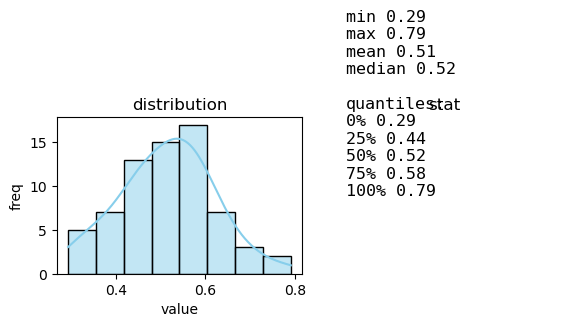

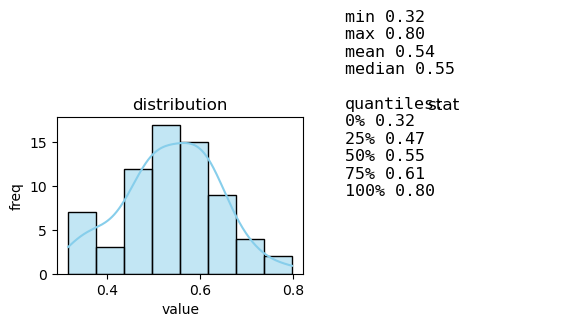

mean iou of vae :0.51334, shift-iou:0.53661
iou quantiles: [0.29297884 0.43850186 0.52453384 0.58036015 0.79108618]
iou_shift quantiles: [0.31611792 0.4718774  0.54550393 0.61232152 0.79748768]
self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([68, 63, 250]), label tensor shape: torch.Size([68]), text length: 68, image length: 68


100%|██████████| 68/68 [00:06<00:00, 11.21it/s]


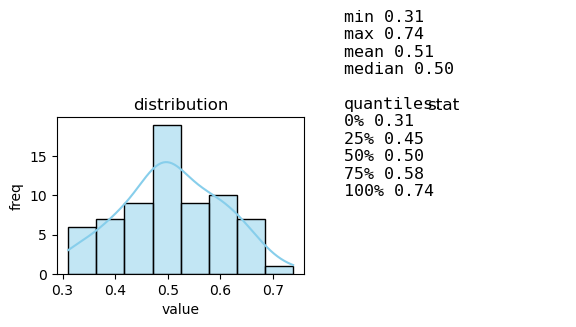

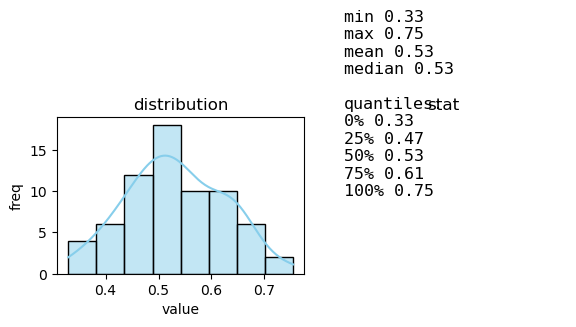

mean iou of vae :0.50750, shift-iou:0.53201
iou quantiles: [0.3108788  0.44587782 0.50349892 0.58226377 0.7379808 ]
iou_shift quantiles: [0.32958797 0.47089402 0.53219068 0.60550791 0.75424792]


In [2]:
from eegdatasets_leaveone_v3 import EEGDataset
import torch
import open_clip
import os
import re
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
import cv2
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution_with_quantiles(data):
    """
    绘制数据分布并显示分位数
    
    参数:
    data -- 输入数据列表
    """
    # 转换为numpy数组
    data_array = np.array(data)
    
    # 计算基本统计量
    min_val = np.min(data_array)
    max_val = np.max(data_array)
    mean_val = np.mean(data_array)
    median_val = np.median(data_array)
    
    # 计算分位数 (0%, 25%, 50%, 75%, 100%)
    quantiles = np.percentile(data_array, [0, 25, 50, 75, 100])
    
    # 创建图形
    plt.figure(figsize=(6, 3))
    
    # 绘制直方图
    plt.subplot(1, 2, 1)
    sns.histplot(data_array, kde=True, color='skyblue')
    plt.title('distribution')
    plt.xlabel('value')
    plt.ylabel('freq')
    
    # 添加统计信息
    stats_text = (f"min {min_val:.2f}\n"
                 f"max {max_val:.2f}\n"
                 f"mean {mean_val:.2f}\n"
                 f"median {median_val:.2f}\n\n"
                 "quantiles:\n"
                 f"0% {quantiles[0]:.2f}\n"
                 f"25% {quantiles[1]:.2f}\n"
                 f"50% {quantiles[2]:.2f}\n"
                 f"75% {quantiles[3]:.2f}\n"
                 f"100% {quantiles[4]:.2f}")
    
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.5, stats_text, fontsize=12, family='monospace')
    plt.axis('off')
    plt.title('stat')
    
    plt.tight_layout()
    plt.show()
    
    return quantiles


def img2clipfeat(clipmodel, Dataloader):
    # 批量推理（自动显存优化）
    all_features = []
    with torch.inference_mode():  # 比torch.no_grad()更高效
        for batch in tqdm(Dataloader):
            batch = batch.to('cuda', non_blocking=True)
            features = clipmodel.encode_image(batch)
            all_features.append(features.cpu())  # 移回CPU释放显存

    all_features = torch.cat(all_features)

    return all_features

# 自定义数据集类（支持批量加载）
class ImageDataset(Dataset):
    def __init__(self, image_paths, preprocess):
        self.image_paths = image_paths
        self.preprocess = preprocess
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        return self.preprocess(Image.open(self.image_paths[idx]))

def get_genfile(directory):
    """
    读取目录下所有文件夹名，并按照文件夹名末尾的数字大小排序
    
    参数:
        directory (str): 要扫描的目录路径
        
    返回:
        list: 按文件夹名末尾数字排序后的文件夹名列表
    """
    # 获取目录下所有文件和文件夹
    items = os.listdir(directory)
    
    # 筛选出文件夹
    folders = [item for item in items if os.path.isdir(os.path.join(directory, item))]
    
    # 定义提取末尾数字的正则表达式
    pattern = re.compile(r'(\d+)$')
    
    # 创建一个列表，包含文件夹名和提取的数字
    folder_with_numbers = []
    for folder in folders:
        match = pattern.search(folder)
        if match:
            number = int(match.group(1))
            folder_with_numbers.append((folder, number))
        else:
            # 如果没有数字，可以设置为一个很大的值或很小的值，取决于你想把它们放在排序的哪一端
            # 这里设置为-1，这样没有数字的文件夹会排在前面
            folder_with_numbers.append((folder, -1))
    
    # 按数字排序
    folder_with_numbers.sort(key=lambda x: x[1])
    
    # 返回排序后的文件夹名列表
    return [folder for folder, number in folder_with_numbers]



def process_controlimg(image_path, mode):
    # mode: edge, shadow, skeleton
    # 读取图像
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("无法加载图像，请检查路径是否正确")
    
    # 增强对比度
    img = cv2.equalizeHist(img)
    
    # 3. 前景(影子)提取
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    ret, thresh = cv2.threshold(blurred, 0, 255, 
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    shadow = cv2.dilate(opening, kernel, iterations=3)
    if mode=='edge':
        # 1. 边缘提取
        v = np.mean(shadow)
        lower = int(max(0, (1.0 - 0.33) * v))
        upper = int(min(255, (1.0 + 0.33) * v))
        edges = cv2.Canny(shadow, lower, upper)
        output = edges
    elif mode=='skeleton':
    # 2. 骨架提取
        skeleton = skeletonize(shadow // 255)
        skeleton = (skeleton * 255).astype(np.uint8)
        output = skeleton
    elif mode=='shadow':
        output = shadow
    
    # 转换为PIL图像
    # output = Image.fromarray(output).convert("RGB")
    
    return output

def calculate_iou(img1, img2):
    """计算两幅二值图像的 IoU"""
    intersection = np.logical_and(img1, img2)
    union = np.logical_or(img1, img2)
    iou = np.sum(intersection) / np.sum(union)
    return iou if not np.isnan(iou) else 0.0

def max_iou_with_translation(img1, img2, max_shift=10):
    """计算平移后的最大 IoU"""
    h, w = img1.shape
    max_iou = 0.0
    best_shift = (0, 0)
    
    for dx in range(-max_shift, max_shift + 1):
        for dy in range(-max_shift, max_shift + 1):
            # 平移 img2
            M = np.float32([[1, 0, dx], [0, 1, dy]])
            shifted_img2 = cv2.warpAffine(img2, M, (w, h), borderValue=0)
            
            # 计算 IoU
            iou = calculate_iou(img1, shifted_img2)
            if iou > max_iou:
                max_iou = iou
                best_shift = (dx, dy)
    
    return max_iou, best_shift

def get_iou(orig_imgs, vae_imgs):
    n_img = len(orig_imgs)
    iou_ls = []
    iou_shift_ls = []
    for i in tqdm(range(n_img)):
        img1 = orig_imgs[i]
        img2 = vae_imgs[i]
        # 1. 预处理（二值化或轮廓提取）
        binary_img1 = process_controlimg(img1, mode='shadow')
        binary_img2 = process_controlimg(img2, mode='shadow')

        # 2. 统一尺寸（调整 img2 到 img1 的尺寸）
        h, w = binary_img1.shape
        resized_img2 = cv2.resize(binary_img2, (w, h), interpolation=cv2.INTER_NEAREST)

        # 3. 计算基本 IoU
        iou = calculate_iou(binary_img1, resized_img2)
        iou_ls.append(iou)
        # print(f"Basic IoU: {iou:.4f}")

        # 4. 计算平移后的最大 IoU
        max_iou, (best_dx, best_dy) = max_iou_with_translation(binary_img1, resized_img2, max_shift=10)
        iou_shift_ls.append(max_iou)
        # print(f"Max IoU with translation: {max_iou:.4f}, Best shift: (dx={best_dx}, dy={best_dy})")

    return iou_ls, iou_shift_ls

def get_vae_imgs(directory):
    """
    读取目录下所有PNG文件，并按文件名末尾的数字排序
    
    参数:
        directory (str): 目标目录路径
        
    返回:
        list: 排序后的PNG文件名列表
    """
    # 获取目录下所有PNG文件
    png_files = [f for f in os.listdir(directory) if f.lower().endswith('.png')]
    
    # 按文件名末尾的数字排序
    png_files.sort(key=lambda x: int(''.join(filter(str.isdigit, x)) if any(c.isdigit() for c in x) else 0))
    
    return png_files
##################### ours
sub = 'sub-01'
data_path = f"/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/splitv3/whiten/Preprocessed_data_250Hz"
# train_dataset = EEGDataset(data_path, subjects=[sub], train=True)
test_dataset = EEGDataset(data_path, subjects=[sub], train=False)
multi_nlist = test_dataset.multi_nlist
##############################
# # 创建vae list
# vae_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/sub-01/06-24_21-23_vae_imgs/epoch_100'
# vae_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/sub-01/06-24_22-39_vae_imgs/epoch_100'
vae_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/sub-01/0707_vae_imgs/epoch_100'
vae_imgs = get_vae_imgs(vae_pth)
vae_imgs = [f'{vae_pth}/{imgfile}' for imgfile in vae_imgs]

# vae-orig iou
ious, ious_shift = get_iou(test_dataset.img, vae_imgs)

iter_vae = 0
ious_max = []
ious_shift_max = []
for i in range(len(multi_nlist)):
    n_1epo = multi_nlist[i]
    iou_1epo = ious[iter_vae:iter_vae+n_1epo]
    iou_shift_1epo = ious_shift[iter_vae:iter_vae+n_1epo]
    iter_vae += n_1epo

    ious_max.append(np.max(iou_1epo))
    ious_shift_max.append(np.max(iou_shift_1epo))

quantiles1 = plot_distribution_with_quantiles(ious)
quantiles2 = plot_distribution_with_quantiles(ious_shift)

print(f'mean iou of vae :{np.mean(ious):.5f}, shift-iou:{np.mean(ious_shift):.5f}')
# print(f'top1 iou outof 10+:{np.mean(ious_max):.5f}, shift-iou:{np.mean(ious_shift_max):.5f}')
print('iou quantiles:',quantiles1)
print('iou_shift quantiles:',quantiles2)
iou_spd = ious.copy()
iou_shift_spd = ious_shift.copy()

##################### orig
sub = 'sub-01'
data_path = f"/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/whiten/Preprocessed_data_250Hz"
# train_dataset = EEGDataset(data_path, subjects=[sub], train=True)
test_dataset = EEGDataset(data_path, subjects=[sub], train=False)
multi_nlist = test_dataset.multi_nlist
##############################
# # 创建vae list
# vae_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/sub-01/06-24_21-23_vae_imgs/epoch_100'
vae_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/sub-01/06-24_22-39_vae_imgs/epoch_100'
# vae_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/sub-01/0707_vae_imgs/epoch_100'
vae_imgs = get_vae_imgs(vae_pth)
vae_imgs = [f'{vae_pth}/{imgfile}' for imgfile in vae_imgs]

# vae-orig iou
ious, ious_shift = get_iou(test_dataset.img, vae_imgs)

iter_vae = 0
ious_max = []
ious_shift_max = []
for i in range(len(multi_nlist)):
    n_1epo = multi_nlist[i]
    iou_1epo = ious[iter_vae:iter_vae+n_1epo]
    iou_shift_1epo = ious_shift[iter_vae:iter_vae+n_1epo]
    iter_vae += n_1epo

    ious_max.append(np.max(iou_1epo))
    ious_shift_max.append(np.max(iou_shift_1epo))

quantiles1 = plot_distribution_with_quantiles(ious)
quantiles2 = plot_distribution_with_quantiles(ious_shift)

print(f'mean iou of vae :{np.mean(ious):.5f}, shift-iou:{np.mean(ious_shift):.5f}')
# print(f'top1 iou outof 10+:{np.mean(ious_max):.5f}, shift-iou:{np.mean(ious_shift_max):.5f}')
print('iou quantiles:',quantiles1)
print('iou_shift quantiles:',quantiles2)

iou_orig = ious.copy()
iou_shift_orig = ious_shift.copy()


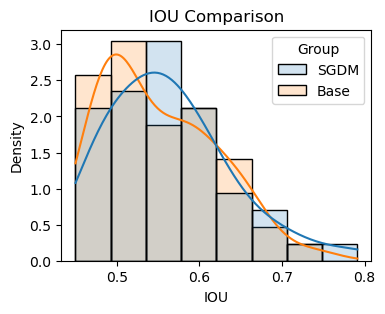

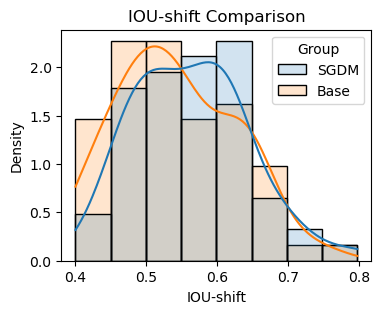

In [11]:
#####################  contrast
limit_left = 0.45
ioupair = [np.array(iou_spd)[np.array(iou_spd)>limit_left], np.array(iou_orig)[np.array(iou_orig)>limit_left]]
df = pd.DataFrame({
    'Value': np.concatenate(ioupair),
    'Group': ['SGDM']*len(ioupair[0]) + ['Base']*len(ioupair[1]),
})
plt.figure(figsize=(4,3))
sns.histplot(
    data=df,
    x='Value',
    hue='Group',
    bins=8,
    stat='density',
    alpha=0.2,
    kde=True,
)
plt.title('IOU Comparison')
plt.xlabel('IOU')
plt.savefig('FigOut/IOU_vae.svg', dpi=300, bbox_inches='tight')
plt.show()

limit_left = 0.40
ioupair = [np.array(iou_shift_spd)[np.array(iou_shift_spd)>limit_left], np.array(iou_shift_orig)[np.array(iou_shift_orig)>limit_left]]
df = pd.DataFrame({
    'Value': np.concatenate(ioupair),
    'Group': ['SGDM']*len(ioupair[0]) + ['Base']*len(ioupair[1]),
})
plt.figure(figsize=(4,3))
sns.histplot(
    data=df,
    x='Value',
    hue='Group',
    bins=8,
    stat='density',
    alpha=0.2,
    kde=True,
)
plt.title('IOU-shift Comparison')
plt.xlabel('IOU-shift')
plt.savefig('FigOut/IOU-shift_vae.svg', dpi=300, bbox_inches='tight')
plt.show()

# eval-things dataset

## import

In [4]:
import torch
import open_clip
import os
import re
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
import cv2
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import csv
import pickle
import pandas as pd

## dataload

In [5]:
def natural_key(s):
    """分割字符串为文字和数字块，用于自然排序"""
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def get_image_paths(root_dir, exts={'.jpg', '.jpeg', '.png', '.bmp', '.gif'}):
    def is_image_file(filename):
        return os.path.splitext(filename)[1].lower() in exts

    result = []

    entries = os.listdir(root_dir)
    full_paths = [os.path.join(root_dir, entry) for entry in entries]

    # 筛选图像文件
    image_files = [f for f in full_paths if os.path.isfile(f) and is_image_file(f)]

    if image_files:
        # 情况 1：目录下直接是图像
        image_files.sort(key=lambda x: natural_key(os.path.basename(x)))
        result = image_files
    else:
        # 情况 2：目录下是文件夹
        # 对子目录进行自然排序
        subdirs = [d for d in full_paths if os.path.isdir(d)]
        subdirs.sort(key=lambda x: natural_key(os.path.basename(x)))

        for subdir in subdirs:
            sub_entries = os.listdir(subdir)
            image_files_in_subdir = [f for f in sub_entries if is_image_file(f)]
            if image_files_in_subdir:
                # 按自然顺序取第一个图像
                image_files_in_subdir.sort(key=natural_key)
                first_img = os.path.join(subdir, image_files_in_subdir[0])
                result.append(first_img)

    return result

sub = f'sub-08'

gen_base_control = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/generated_imgs/base_control/sub-08/dif'
vae_control = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/basecon/sub-08/0722-4_vae_imgs/epoch_174'

gen_base = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/generated_imgs/base/sub-08/dif'
vae_base = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/base/sub-08/07-18_14-35_vae_imgs_test/epoch_90' # 200, but name different

img_test = f'/home/nncc/lyx/project/EEG_Image_decode-main/download/test_images' # 200, with folder
gen_basepaper = '/home/nncc/lyx/project/EEG_Image_decode-main/download/EEG_Image_decode/generated_imgs/sub-08' # 200*10
img_test_sam = f'/home/nncc/lyx/project/EEG_Image_decode-main/download/test_sam' # 200, with folder

imgset_name = ['gen_base_control','vae_control','gen_base','vae_base','img_test','gen_basepaper','img_test_sam']
imgsets = [gen_base_control,vae_control,gen_base,vae_base,img_test,gen_basepaper,img_test_sam]
imgpths = {}

for i in range(len(imgsets)):
    imgpths[imgset_name[i]] = get_image_paths(imgsets[i])

labels = [imgpths['img_test_sam'][i].split('/')[-2] for i in range(200)]

## select

100%|██████████| 200/200 [00:20<00:00,  9.55it/s]


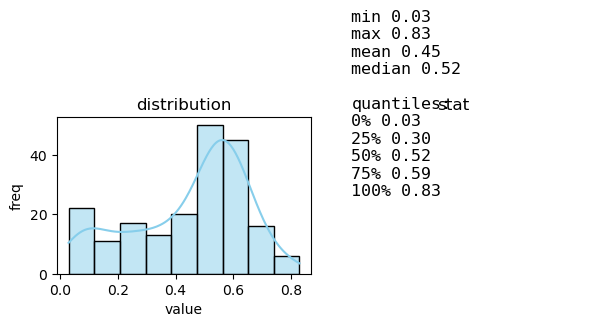

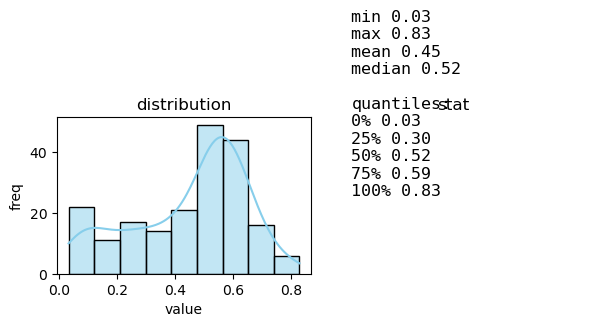

In [44]:
# iou select
# vae_control -- img_test_sam

def get_iou(orig_imgs, vae_imgs):
    n_img = len(orig_imgs)
    iou_ls = []
    iou_shift_ls = []
    for i in tqdm(range(n_img)):
        img1 = orig_imgs[i]
        img2 = vae_imgs[i]
        # 1. 预处理（二值化或轮廓提取）
        binary_img1 = process_controlimg(img1, mode='shadow')
        binary_img2 = process_controlimg(img2, mode='shadow')

        # 2. 统一尺寸（调整 img2 到 img1 的尺寸）
        h, w = binary_img1.shape
        resized_img2 = cv2.resize(binary_img2, (w, h), interpolation=cv2.INTER_NEAREST)

        # 3. 计算基本 IoU
        iou = calculate_iou(binary_img1, resized_img2)
        iou_ls.append(iou)
        # print(f"Basic IoU: {iou:.4f}")

        # 4. 计算平移后的最大 IoU
        max_iou, (best_dx, best_dy) = max_iou_with_translation(binary_img1, resized_img2, max_shift=10)
        iou_shift_ls.append(max_iou)
        # print(f"Max IoU with translation: {max_iou:.4f}, Best shift: (dx={best_dx}, dy={best_dy})")

    return iou_ls, iou_shift_ls

def calculate_iou(img1, img2):
    """计算两幅二值图像的 IoU"""
    intersection = np.logical_and(img1, img2)
    union = np.logical_or(img1, img2)
    iou = np.sum(intersection) / np.sum(union)
    return iou if not np.isnan(iou) else 0.0

def max_iou_with_translation(img1, img2, max_shift=10):
    """计算平移后的最大 IoU"""
    h, w = img1.shape
    max_iou = 0.0
    best_shift = (0, 0)
    
    for dx in range(-max_shift, max_shift + 1):
        for dy in range(-max_shift, max_shift + 1):
            # 平移 img2
            M = np.float32([[1, 0, dx], [0, 1, dy]])
            shifted_img2 = cv2.warpAffine(img2, M, (w, h), borderValue=0)
            
            # 计算 IoU
            iou = calculate_iou(img1, shifted_img2)
            if iou > max_iou:
                max_iou = iou
                best_shift = (dx, dy)
    
    return max_iou, best_shift

def process_controlimg(image_path, mode):
    # mode: edge, shadow, skeleton
    # 读取图像
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("无法加载图像，请检查路径是否正确")
    
    # 增强对比度
    img = cv2.equalizeHist(img)
    
    # 3. 前景(影子)提取
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    ret, thresh = cv2.threshold(blurred, 0, 255, 
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    shadow = cv2.dilate(opening, kernel, iterations=3)
    if mode=='edge':
        # 1. 边缘提取
        v = np.mean(shadow)
        lower = int(max(0, (1.0 - 0.33) * v))
        upper = int(min(255, (1.0 + 0.33) * v))
        edges = cv2.Canny(shadow, lower, upper)
        output = edges
    elif mode=='skeleton':
    # 2. 骨架提取
        skeleton = skeletonize(shadow // 255)
        skeleton = (skeleton * 255).astype(np.uint8)
        output = skeleton
    elif mode=='shadow':
        output = shadow
    
    # 转换为PIL图像
    # output = Image.fromarray(output).convert("RGB")
    
    return output

def plot_distribution_with_quantiles(data):
    """
    绘制数据分布并显示分位数
    
    参数:
    data -- 输入数据列表
    """
    # 转换为numpy数组
    data_array = np.array(data)
    
    # 计算基本统计量
    min_val = np.min(data_array)
    max_val = np.max(data_array)
    mean_val = np.mean(data_array)
    median_val = np.median(data_array)
    
    # 计算分位数 (0%, 25%, 50%, 75%, 100%)
    quantiles = np.percentile(data_array, [0, 25, 50, 75, 100])
    
    # 创建图形
    plt.figure(figsize=(6, 3))
    
    # 绘制直方图
    plt.subplot(1, 2, 1)
    sns.histplot(data_array, kde=True, color='skyblue')
    plt.title('distribution')
    plt.xlabel('value')
    plt.ylabel('freq')
    
    # 添加统计信息
    stats_text = (f"min {min_val:.2f}\n"
                 f"max {max_val:.2f}\n"
                 f"mean {mean_val:.2f}\n"
                 f"median {median_val:.2f}\n\n"
                 "quantiles:\n"
                 f"0% {quantiles[0]:.2f}\n"
                 f"25% {quantiles[1]:.2f}\n"
                 f"50% {quantiles[2]:.2f}\n"
                 f"75% {quantiles[3]:.2f}\n"
                 f"100% {quantiles[4]:.2f}")
    
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.5, stats_text, fontsize=12, family='monospace')
    plt.axis('off')
    plt.title('stat')
    
    plt.tight_layout()
    plt.show()
    
    return quantiles

ious, ious_shift = get_iou(imgpths['img_test_sam'], imgpths['vae_control'])
quantiles1 = plot_distribution_with_quantiles(ious)
quantiles2 = plot_distribution_with_quantiles(ious_shift)

def topk_above_m(arr,m,k):
    arr = np.array(arr)
    mask = arr>m
    inds = np.where(mask)[0]
    values = arr[inds]
    sorted_inds = inds[np.argsort(-values)]
    if len(sorted_inds)>k:
        return sorted_inds[:k]
    else:
        return sorted_inds

iou_k = 30
iou_min = 0.65

sel_inds = topk_above_m(ious_shift, iou_min, iou_k)

## visual

In [45]:
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def draw_grid_from_lists(image_lists, label_list, output_dir, sel_inds, save_name='grid_output.png'):
    os.makedirs(output_dir, exist_ok=True)

    num_rows = len(sel_inds)     # 行数
    num_cols = len(image_lists)    # 应该为 7
    assert num_cols == 7, "必须输入 7 个图像列表"
    
    for lst in image_lists:
        assert len(lst) == len(label_list), "每个图像列表必须有和标签相同的数量"

    # 加载图像并保持大小一致
    def load_image(path, size=(128, 128)):
        img = Image.open(path).convert('RGB')
        img = img.resize(size)
        return img

    cell_size = (128, 128)
    spacing = 10
    label_height = 40
    grid_width = num_cols * cell_size[0] + (num_cols - 1) * spacing
    grid_height = num_rows * (cell_size[1] + label_height) + (num_rows - 1) * spacing

    grid_img = Image.new('RGB', (grid_width, grid_height), color='white')
    draw = ImageDraw.Draw(grid_img)

    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    for row in range(num_rows):
        rowi = sel_inds[row]
        for col in range(num_cols):
            img_path = image_lists[col][rowi]
            img = load_image(img_path, size=cell_size)

            x = col * (cell_size[0] + spacing)
            y = row * (cell_size[1] + label_height + spacing)
            grid_img.paste(img, (x, y))

        # 写 label（整行居中）
        label_text = str(label_list[rowi])
        bbox = draw.textbbox((0, 0), label_text, font=font)
        text_w = bbox[2] - bbox[0]
        text_h = bbox[3] - bbox[1]
        label_x = (grid_width - text_w) // 2
        label_y = row * (cell_size[1] + label_height + spacing) + cell_size[1]
        draw.text((label_x, label_y), label_text, fill='black', font=font)

    output_path = os.path.join(output_dir, save_name)
    grid_img.save(output_path)
    print(f"图像保存到：{output_path}")

imgset_name = ['gen_base_control','vae_control','gen_base','vae_base','img_test','gen_basepaper','img_test_sam']

output_dir = f'visualizations/things/sub-08'
image_lists=[
    imgpths['img_test'], 
    imgpths['img_test_sam'], imgpths['vae_base'], imgpths['vae_control'], 
    imgpths['gen_basepaper'], imgpths['gen_base'], imgpths['gen_base_control'],
    ]

draw_grid_from_lists(
    image_lists=image_lists,
    label_list=labels,
    output_dir=output_dir,
    sel_inds=sel_inds,
    save_name='comparison_grid.png'
)

图像保存到：visualizations/things/sub-08/comparison_grid.png


## metrics

In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import csv
import pickle

from PIL import Image
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm import tqdm
from eegdatasets_tang_clip2 import EEGDataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

# !!!!!!!! load data first
# 'gen_base_control','gen_base','gen_basepaper'------'img_test'

@torch.no_grad()
def two_way_identification(all_brain_recons, all_images, model, preprocess, feature_layer=None, return_avg=True):
    preds = model(torch.stack([preprocess(recon) for recon in all_brain_recons], dim=0).to(device))
    reals = model(torch.stack([preprocess(indiv) for indiv in all_images], dim=0).to(device))
    if feature_layer is None:
        preds = preds.float().flatten(1).cpu().numpy()
        reals = reals.float().flatten(1).cpu().numpy()
    else:
        preds = preds[feature_layer].float().flatten(1).cpu().numpy()
        reals = reals[feature_layer].float().flatten(1).cpu().numpy()

    r = np.corrcoef(reals, preds)
    r = r[:len(all_images), len(all_images):]
    congruents = np.diag(r)

    success = r < congruents
    success_cnt = np.sum(success, 0)

    if return_avg:
        perf = np.mean(success_cnt) / (len(all_images)-1)
        return perf
    else:
        return success_cnt, len(all_images)-1
    

def resize_batch(batch_size, data, resize):
    resized_data = []
    for i in range(0, data.shape[0], batch_size):
        batch = data[i:i+batch_size]
        batch = batch.permute(0, 3, 1, 2)  # (B, H, W, C) -> (B, C, H, W)（PyTorch 要求）
        resized_batch = resize(batch)
        resized_data.append(resized_batch)

    # 合并结果
    resized_data = torch.cat(resized_data, dim=0)  # (200, 3, 256, 256)
    return resized_data

def img2tensor(imgls):
    tensor_list = []
    for imgi in imgls:
        with Image.open(imgi) as img:
            # Convert the image to a PyTorch tensor and add a batch dimension
            tensor = torch.tensor(np.array(img)).unsqueeze(0)
            tensor_list.append(tensor)
    # Concatenate all tensors along the 0th dimension
    all_tensors = torch.cat(tensor_list, dim=0)
    return all_tensors

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
subjects = ['sub-08']
date_code = '0722'
img_orig = imgpths['img_test']
img_gens = [imgpths['gen_base_control'], imgpths['gen_base'], imgpths['gen_basepaper']]
img_gen_names = ['gen_base_control','gen_base','gen_basepaper']

exp = '0722'
result_mean = []
result_mean_dir = f'./outputs/eval/{date_code}'
os.makedirs(result_mean_dir, exist_ok=True)

# subjects = ['sub-01']
for sub in subjects:
    all_images = img2tensor(img_orig)
    resize = transforms.Resize((256, 256))
    all_images = resize_batch(8, all_images, resize)
    for img_geni in range(len(img_gens)):
        #######################################
        all_brain_recons = img2tensor(img_gens[img_geni])
        genname = img_gen_names[img_geni]
        result_detail = {}
        result_detail_dir = f'{result_mean_dir}/{sub}_{genname}.pkl'
        ############# resize ###############
        resize = transforms.Resize((256, 256))
        all_brain_recons = resize_batch(8, all_brain_recons, resize)

        ############ dim match ##############
        gen_n = int(all_brain_recons.shape[0]/all_images.shape[0])
        # all_images = torch.repeat_interleave(all_images, repeats=gen_n, dim=0)

        print(all_images.shape)
        print(all_brain_recons.shape)

        ############################### SSIM
        # see https://github.com/zijin-gu/meshconv-decoding/issues/3
        from skimage.color import rgb2gray
        from skimage.metrics import structural_similarity as ssim

        # convert image to grayscale with rgb2grey
        img_gray = rgb2gray(all_images.permute((0,2,3,1)))
        recon_gray = rgb2gray(all_brain_recons.permute((0,2,3,1)))
        print("converted, now calculating ssim...")

        ssim_score=[]
        for im,rec in tqdm(zip(img_gray,recon_gray),total=len(all_images)):
            ssim_score.append(ssim(rec, im, multichannel=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=1.0))

        ssim_m = np.mean(ssim_score)
        print(ssim_m)

        result_detail['ssim'] = ssim_score.copy()

        ######################## AlexNet
        from torchvision.models import alexnet, AlexNet_Weights
        alex_weights = AlexNet_Weights.IMAGENET1K_V1

        alex_model = create_feature_extractor(alexnet(weights=alex_weights), return_nodes=['features.4','features.11']).to(device)
        alex_model.eval().requires_grad_(False)

        # see alex_weights.transforms()
        preprocess = transforms.Compose([
            transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
        ])

        layer = 'early, AlexNet(2)'
        print(f"\n---{layer}---")
        all_per_correct, n = two_way_identification(all_brain_recons.to(device).float(), all_images.float(), 
                                                                alex_model, preprocess, 'features.4', return_avg=False)
        alexnet2 = np.mean(all_per_correct)/n
        print(f"2-way Percent Correct: {alexnet2:.4f}")
        result_detail['alexnet2'] = all_per_correct.copy()

        layer = 'mid, AlexNet(5)'
        print(f"\n---{layer}---")
        all_per_correct, n = two_way_identification(all_brain_recons.to(device).float(), all_images.float(), 
                                                                alex_model, preprocess, 'features.11', return_avg=False)
        alexnet5 = np.mean(all_per_correct)/n
        print(f"2-way Percent Correct: {alexnet5:.4f}")
        result_detail['alexnet5'] = all_per_correct.copy()

        ####################### inception
        from torchvision.models import inception_v3, Inception_V3_Weights
        weights = Inception_V3_Weights.DEFAULT
        inception_model = create_feature_extractor(inception_v3(weights=weights), 
                                                return_nodes=['avgpool']).to(device)
        inception_model.eval().requires_grad_(False)

        # see weights.transforms()
        preprocess = transforms.Compose([
            transforms.Resize(342, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
        ])

        all_per_correct, n = two_way_identification(all_brain_recons.float(), all_images.float(),
                                                inception_model, preprocess, 'avgpool', return_avg=False)
                
        inception = np.mean(all_per_correct)/n
        print(f"2-way Percent Correct: {inception:.4f}")

        result_detail['inception'] = all_per_correct.copy()

        ####################### CLIP
        import clip
        clip_model, preprocess = clip.load("ViT-L/14", device=device)

        preprocess = transforms.Compose([
            transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                std=[0.26862954, 0.26130258, 0.27577711]),
        ])

        all_per_correct, n = two_way_identification(all_brain_recons.float(), all_images.float(),
                                                clip_model.encode_image, preprocess, None, return_avg=False) # final layer
        clip_ = np.mean(all_per_correct)/n
        print(f"2-way Percent Correct: {clip_:.4f}")
        result_detail['clip'] = all_per_correct.copy()

        ##########################  effocientNet
        # from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
        # weights = EfficientNet_B1_Weights.DEFAULT
        # eff_model = create_feature_extractor(efficientnet_b1(weights=weights), 
        #                                     return_nodes=['avgpool']).to(device)
        # eff_model.eval().requires_grad_(False)

        # # see weights.transforms()
        # preprocess = transforms.Compose([
        #     transforms.Resize(255, interpolation=transforms.InterpolationMode.BILINEAR),
        #     transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                         std=[0.229, 0.224, 0.225]),
        # ])

        # gt = eff_model(preprocess(all_images.float()))['avgpool']
        # gt = gt.reshape(len(gt),-1).cpu().numpy()
        # fake = eff_model(preprocess(all_brain_recons.float()))['avgpool']
        # fake = fake.reshape(len(fake),-1).cpu().numpy()

        # effnet = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
        # print("Distance:",effnet)
        # result_detail['effnet'] = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).copy()

        ######################### SwAV
        proxy = 'http://127.0.0.1:7897'
        os.environ['http_proxy'] = proxy
        os.environ['https_proxy'] = proxy

        swav_model = torch.hub.load('facebookresearch/swav:main', 'resnet50')
        swav_model = create_feature_extractor(swav_model, 
                                            return_nodes=['avgpool']).to(device)
        swav_model.eval().requires_grad_(False)

        preprocess = transforms.Compose([
            transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
        ])

        gt = swav_model(preprocess(all_images.float().to(device)))['avgpool']
        gt = gt.reshape(len(gt),-1).cpu().numpy()
        fake = swav_model(preprocess(all_brain_recons.float().to(device)))['avgpool']
        fake = fake.reshape(len(fake),-1).cpu().numpy()

        swav = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
        print("Distance:",swav)
        result_detail['swav'] = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).copy()

        ########## result
        result_epo = {
            'sub': sub,
            'emb': genname,
            'ssim': ssim_m,
            'alexnet2': alexnet2,
            'alexnet5': alexnet5,
            'inception': inception,
            'clip': clip_,
            # 'effnet': effnet,
            'swav': swav,
        }
        result_mean.append(result_epo)

        with open(result_detail_dir,'wb') as f:
            pickle.dump(result_detail, f)

result_mean_file = f'{result_mean_dir}/allsub.csv'
with open(result_mean_file, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=result_mean[0].keys())
    writer.writeheader()
    writer.writerows(result_mean)
    print(f'Results saved to {result_mean_file}')

1


NameError: name 'imgpths' is not defined

In [11]:
result_mean_dir = f'./outputs/eval/0722'
df_metrics = pd.read_csv(f'{result_mean_dir}/allsub.csv')
df_metrics

,sub,emb,ssim,alexnet2,alexnet5,inception,clip,swav
0,sub-08,gen_base_control,0.279236,0.593317,0.598693,0.680151,0.642839,0.049506
1,sub-08,gen_base,0.249993,0.585427,0.634447,0.648794,0.608367,0.056565
2,sub-08,gen_basepaper,0.264188,0.628241,0.667789,0.730000,0.693492,0.059115


# eval-tang-ablation

In [5]:
############ read metrics
subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12',
    'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24']
# subjects = ['sub-01']
data_path = "/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/splitv3/whiten/Preprocessed_data_250Hz"
embs = ['dif','eeg','img']

date_code = '1015' ######## change date
metric_dirs = f'./outputs/eval/{date_code}/allsub_ablation.csv'
df_metrics = pd.read_csv(metric_dirs)
avg_dfi = df_metrics.groupby('control').mean(numeric_only=True)
print(avg_dfi)
avg_dfi.to_csv(f'./outputs/eval/eval_tang_ablation.csv')

             ssim  alexnet2  alexnet5  inception      clip      swav  \
control                                                                
0.00     0.253021  0.486137  0.485692   0.487460  0.485840  0.057032   
0.25     0.277510  0.484702  0.481625   0.480000  0.483007  0.054544   
0.50     0.307875  0.485757  0.483275   0.489237  0.489208  0.050399   
0.75     0.344851  0.485101  0.483325   0.485594  0.486461  0.049678   
1.00     0.372699  0.484455  0.483690   0.485119  0.487447  0.049720   

         swav_corr   swav_fid        IS         FID  
control                                              
0.00      0.051067  39.912581  6.864199  100.035602  
0.25      0.048827  38.890684  6.829069  105.694520  
0.50      0.045107  38.423553  6.297799  115.751052  
0.75      0.044457  40.161633  5.777732  114.918105  
1.00      0.044483  43.162451  4.979582  116.743718  
